In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import load, Variable, Column
from aggregate import agg_dates
from clean import remove_duplicates, fill_missing, filter_outliers
from plot_utils import get_values
from transform import return_transformed, transform_aggregated

df = load("dataset_mood_smartphone.csv")

# Data preparation
#### Exploratory data analyis

In [44]:
t = df.set_index("time").groupby("variable").describe()
t.to_latex("output/tables/table_raw.tex")
t

value                                               \
                        count        mean         std        min       25%   
variable                                                                     
activity              22965.0    0.115958    0.186946      0.000   0.00000   
appCat.builtin        91288.0   18.538262  415.989243 -82798.871   2.02000   
appCat.communication  74276.0   43.343792  128.912750      0.006   5.21800   
appCat.entertainment  27125.0   37.576480  262.960476     -0.011   1.33400   
appCat.finance          939.0   21.755251   39.218361      0.131   4.07200   
appCat.game             813.0  128.391615  327.145246      1.003  14.14800   
appCat.office          5642.0   22.578892  449.601382      0.003   2.00400   
appCat.other           7650.0   25.810839  112.781355      0.014   7.01900   
appCat.social         19145.0   72.401906  261.551846      0.094   9.03000   
appCat.travel          2846.0   45.730850  246.109307      0.080   5.08650   
appCat.unknown          939.0   45.553006  119.400405      0.111   5.01800   
appCat.utilities       2487.0   18.537552   60.959134      0.246   3.15850   
appCat.weather          255.0   20.148714   24.943431      1.003   8.68400   
call                   5239.0    1.000000    0.000000      1.000   1.00000   
circumplex.arousal     5597.0   -0.098624    1.051868     -2.000  -1.00000   
circumplex.valence     5487.0    0.687808    0.671298     -2.000   0.00000   
mood                   5641.0    6.992555    1.032769      1.000   7.00000   
screen                96578.0   75.335206  253.822497      0.035   5.32225   
sms                    1798.0    1.000000    0.000000      1.000   1.00000   

                                                        
                            50%         75%        max  
variable                                                
activity               0.021739    0.158333      1.000  
appCat.builtin         4.038000    9.922000  33960.246  
appCat.communication  16.225500   45.475750   9830.777  
appCat.entertainment   3.391000   14.922000  32148.677  
appCat.finance         8.026000   20.155000    355.513  
appCat.game           43.168000  123.625000   5491.793  
appCat.office          3.106000    8.043750  32708.818  
appCat.other          10.028000   16.829250   3892.038  
appCat.social         28.466000   75.372000  30000.906  
appCat.travel         18.144000   47.227250  10452.615  
appCat.unknown        17.190000   44.430500   2239.937  
appCat.utilities       8.030000   19.331000   1802.649  
appCat.weather        15.117000   25.349000    344.863  
call                   1.000000    1.000000      1.000  
circumplex.arousal     0.000000    1.000000      2.000  
circumplex.valence     1.000000    1.000000      2.000  
mood                   7.000000    8.000000     10.000  
screen                20.044500   62.540250   9867.007  
sms                    1.000000    1.000000      1.000

### Data Cleaning
#### Handling duplicate rows, filling `N/A` values and dealing with outliers
The following is done in order:
- To handle **duplicate** rows: We consider them incorrect values and just delete the rows
- To fill **missing** values: This happens just for `circumplex.arousal` and `circumplex.valence`. 
Forward filling (`ffill`) and backward filling (`bfill`) do the job and they both make sense for 
time ordered data.
- To handle **outliers**: 
Example of duplicate rows

In [45]:
df[df[["id", "time", "variable"]].duplicated(keep=False)][:2]

,id,time,variable,value
135,AS14.01,2014-04-17 11:00:00,mood,7.0
136,AS14.01,2014-04-17 11:00:00,mood,6.0


In [46]:
print(f"There are {len(df[df[['id', 'time', 'variable']].duplicated(keep=False)])} duplicated rows in total.")

There are 86 duplicated rows in total.


Example of missing values

In [47]:
df[df.isna().any(axis=1)][:2]

,id,time,variable,value
5708,AS14.01,2014-04-02 18:00:00,circumplex.arousal,NaN
5730,AS14.01,2014-04-07 15:00:00,circumplex.arousal,NaN


In [48]:
print(f"""There are {len(df[df.isna().any(axis=1)])} missing values in total,
juust for the variables {set(df[df.isna().any(axis=1)]["variable"])}""")

There are 202 missing values in total,
juust for the variables {'circumplex.valence', 'circumplex.arousal'}


It's not difficult to guess that there are quite a few extreme values looking at the variables table
above. For example for the `appCat.builtin` variable we can visually identify a very extreme value
that we want to remove (since a negative time is not possible).


...

In [49]:
df[(df["variable"] == Variable.BUILTIN) & (df["value"] < 0)]

,id,time,variable,value
150040,AS14.02,2014-03-16 15:46:43.769,appCat.builtin,-44.689
159972,AS14.07,2014-04-30 14:18:06.200,appCat.builtin,-82798.871
162154,AS14.12,2014-04-02 16:42:16.523,appCat.builtin,-1.218


All the variables are inspected visually using boxplots. After doing so, we conclude that the 
following rules are sensible to filter what we consider incorrect values **and** outliers (which 
could be possible but we consider them as errors in the measurements)

The rules are summarized below

| Variable (x)           | Filter condition                       |
|------------------------|----------------------------------------|
| mood                   | $0 \leq x \leq 10$                     |
| circumplex.arousal     | $-2 \leq x \leq 2$                     |
| circumplex.valence     | $-2 \leq x \leq 2$                     |
| activity               | $0 \leq x \leq 1$                      |
| screen                 | $x \geq 0$                             |
| call                   | $x = 1$                                |
| sms                    | $x = 1$                                |
| appCat.builtin         | $x \geq 0$                             |
| appCat.communication   | $0 \leq x \leq 7200$                   |
| appCat.entertainment   | $0 \leq x \leq 7200$                   |
| appCat.finance         | $0 \leq x \leq 7200$                   |
| appCat.game            | $0 \leq x \leq 7200$                   |
| appCat.office          | $0 \leq x \leq 7200$                   |
| appCat.other           | $0 \leq x \leq 7200$                   |
| appCat.social          | $0 \leq x \leq 7200$                   |
| appCat.travel          | $0 \leq x \leq 7200$                   |
| appCat.unknown         | $0 \leq x \leq 7200$                   |
| appCat.utilities       | $0 \leq x \leq 7200$                   |
| appCat.weather         | $0 \leq x \leq 7200$                   |


We know that some of the variables are bounded to a certain closed interval so we restrict their 
values accordingly. For the `appCat.*` variables we set a limit of 2 hours of usage, except for 
the `appCat.builtin`, that we think higher values can be possible (apps running in the background).
*I think copy pasting the markdown code for the table to ChatGPT and asking to convert it to Latex 
can be nice for the report*

In [50]:
cleaned = filter_outliers(fill_missing(remove_duplicates(df, keep=False), limit=5))
cleaned.to_csv("output/data/cleaned.csv")
cleaned

,id,variable,time,value
0,AS14.01,mood,2014-02-26 13:00:00.000,6.000
1,AS14.01,mood,2014-02-26 15:00:00.000,6.000
2,AS14.01,mood,2014-02-26 18:00:00.000,6.000
3,AS14.01,mood,2014-02-26 21:00:00.000,7.000
4,AS14.01,mood,2014-02-27 09:00:00.000,6.000
...,...,...,...,...
376821,AS14.30,appCat.weather,2014-04-11 07:51:16.948,8.032
376822,AS14.30,appCat.weather,2014-04-19 11:00:32.747,3.008
376823,AS14.30,appCat.weather,2014-04-26 10:19:07.434,7.026
376824,AS14.30,appCat.weather,2014-04-27 00:44:48.450,23.033


In [51]:
t = cleaned.set_index("time").groupby("variable").describe()
t.to_latex("output/tables/table_cleaned.tex")
t

value                                           \
                        count        mean         std    min       25%   
variable                                                                 
activity              22965.0    0.115958    0.186946  0.000   0.00000   
appCat.builtin        91285.0   19.446411  312.914956  0.001   2.02000   
appCat.communication  74273.0   42.965217  114.308316  0.006   5.21800   
appCat.entertainment  27121.0   35.513914  139.703170  0.001   1.33400   
appCat.finance          939.0   21.755251   39.218361  0.131   4.07200   
appCat.game             813.0  128.391615  327.145246  1.003  14.14800   
appCat.office          5641.0   16.784487  112.750923  0.003   2.00400   
appCat.other           7650.0   25.810839  112.781355  0.014   7.01900   
appCat.social         19144.0   70.838570  147.036547  0.094   9.02975   
appCat.travel          2845.0   42.072894  149.987986  0.080   5.08600   
appCat.unknown          939.0   45.553006  119.400405  0.111   5.01800   
appCat.utilities       2487.0   18.537552   60.959134  0.246   3.15850   
appCat.weather          255.0   20.148714   24.943431  1.003   8.68400   
call                   5239.0    1.000000    0.000000  1.000   1.00000   
circumplex.arousal     5613.0   -0.098878    1.050585 -2.000  -1.00000   
circumplex.valence     5613.0    0.690005    0.669119 -2.000   0.00000   
mood                   5615.0    6.995191    1.031294  1.000   7.00000   
screen                96578.0   75.335206  253.822497  0.035   5.32225   
sms                    1798.0    1.000000    0.000000  1.000   1.00000   

                                                        
                            50%         75%        max  
variable                                                
activity               0.021739    0.158333      1.000  
appCat.builtin         4.038000    9.922000  33960.246  
appCat.communication  16.225000   45.471000   6053.176  
appCat.entertainment   3.388000   14.921000   4877.670  
appCat.finance         8.026000   20.155000    355.513  
appCat.game           43.168000  123.625000   5491.793  
appCat.office          3.106000    8.043000   5691.982  
appCat.other          10.028000   16.829250   3892.038  
appCat.social         28.443000   75.369750   6343.129  
appCat.travel         18.144000   47.192000   6735.321  
appCat.unknown        17.190000   44.430500   2239.937  
appCat.utilities       8.030000   19.331000   1802.649  
appCat.weather        15.117000   25.349000    344.863  
call                   1.000000    1.000000      1.000  
circumplex.arousal     0.000000    1.000000      2.000  
circumplex.valence     1.000000    1.000000      2.000  
mood                   7.000000    8.000000     10.000  
screen                20.044500   62.540250   9867.007  
sms                    1.000000    1.000000      1.000

### Feature engineering

In [52]:
# Clean df with transformed variables
transformed = return_transformed(cleaned)
transformed.to_csv("output/data/transformed.csv")


We transform every variable that measures screen time with the $\log$ function, so the distributions
of most variables look approximately normal (see table)

| Variable (x)           | Distribution                              |
|------------------------|-------------------------------------------|
| mood                   | $\sim N(7, 1)$                            |
| circumplex.arousal     | $\sim N(0, 1)$                            |
| circumplex.valence     | $\sim N(0, 0.5)$ with heavy left tail     |
| activity               | exponential between 0 and 1               |
| log(screen)            | $\sim N(3, 2)$                            |
| call                   | uniform $[1, 1]$                          |
| sms                    | uniform $[1, 1]$                          |
| log(appCat.builtin)    | $\sim N(1.5, 1)$                          |
| log(appCat.communication)| $\sim N(3, 2.5)$                        |
| log(appCat.entertainment)| just right tail of $\sim N(0, 2)$        |
| log(appCat.finance)    | $\sim N(2, 1)$ heavy right tail           |
| log(appCat.game)       | $\sim N(4, 1.5)$                          |
| log(appCat.office)     | just right tail of $\sim N(0, 1)$         |
| log(appCat.other)      | $\sim N(2, 1)$                            |
| log(appCat.social)     | $\sim N(3, 1.5)$                          |
| log(appCat.travel)     | $\sim N(3, 1)$ heavy left tail            |
| log(appCat.unknown)    | $\sim N(2.5, 1.5)$ heavy left tail        |
| log(appCat.utilities)  | $\sim N(2, 1)$                            |
| log(appCat.weather)    | $\sim N(2.5, 1)$ heay left tail           |

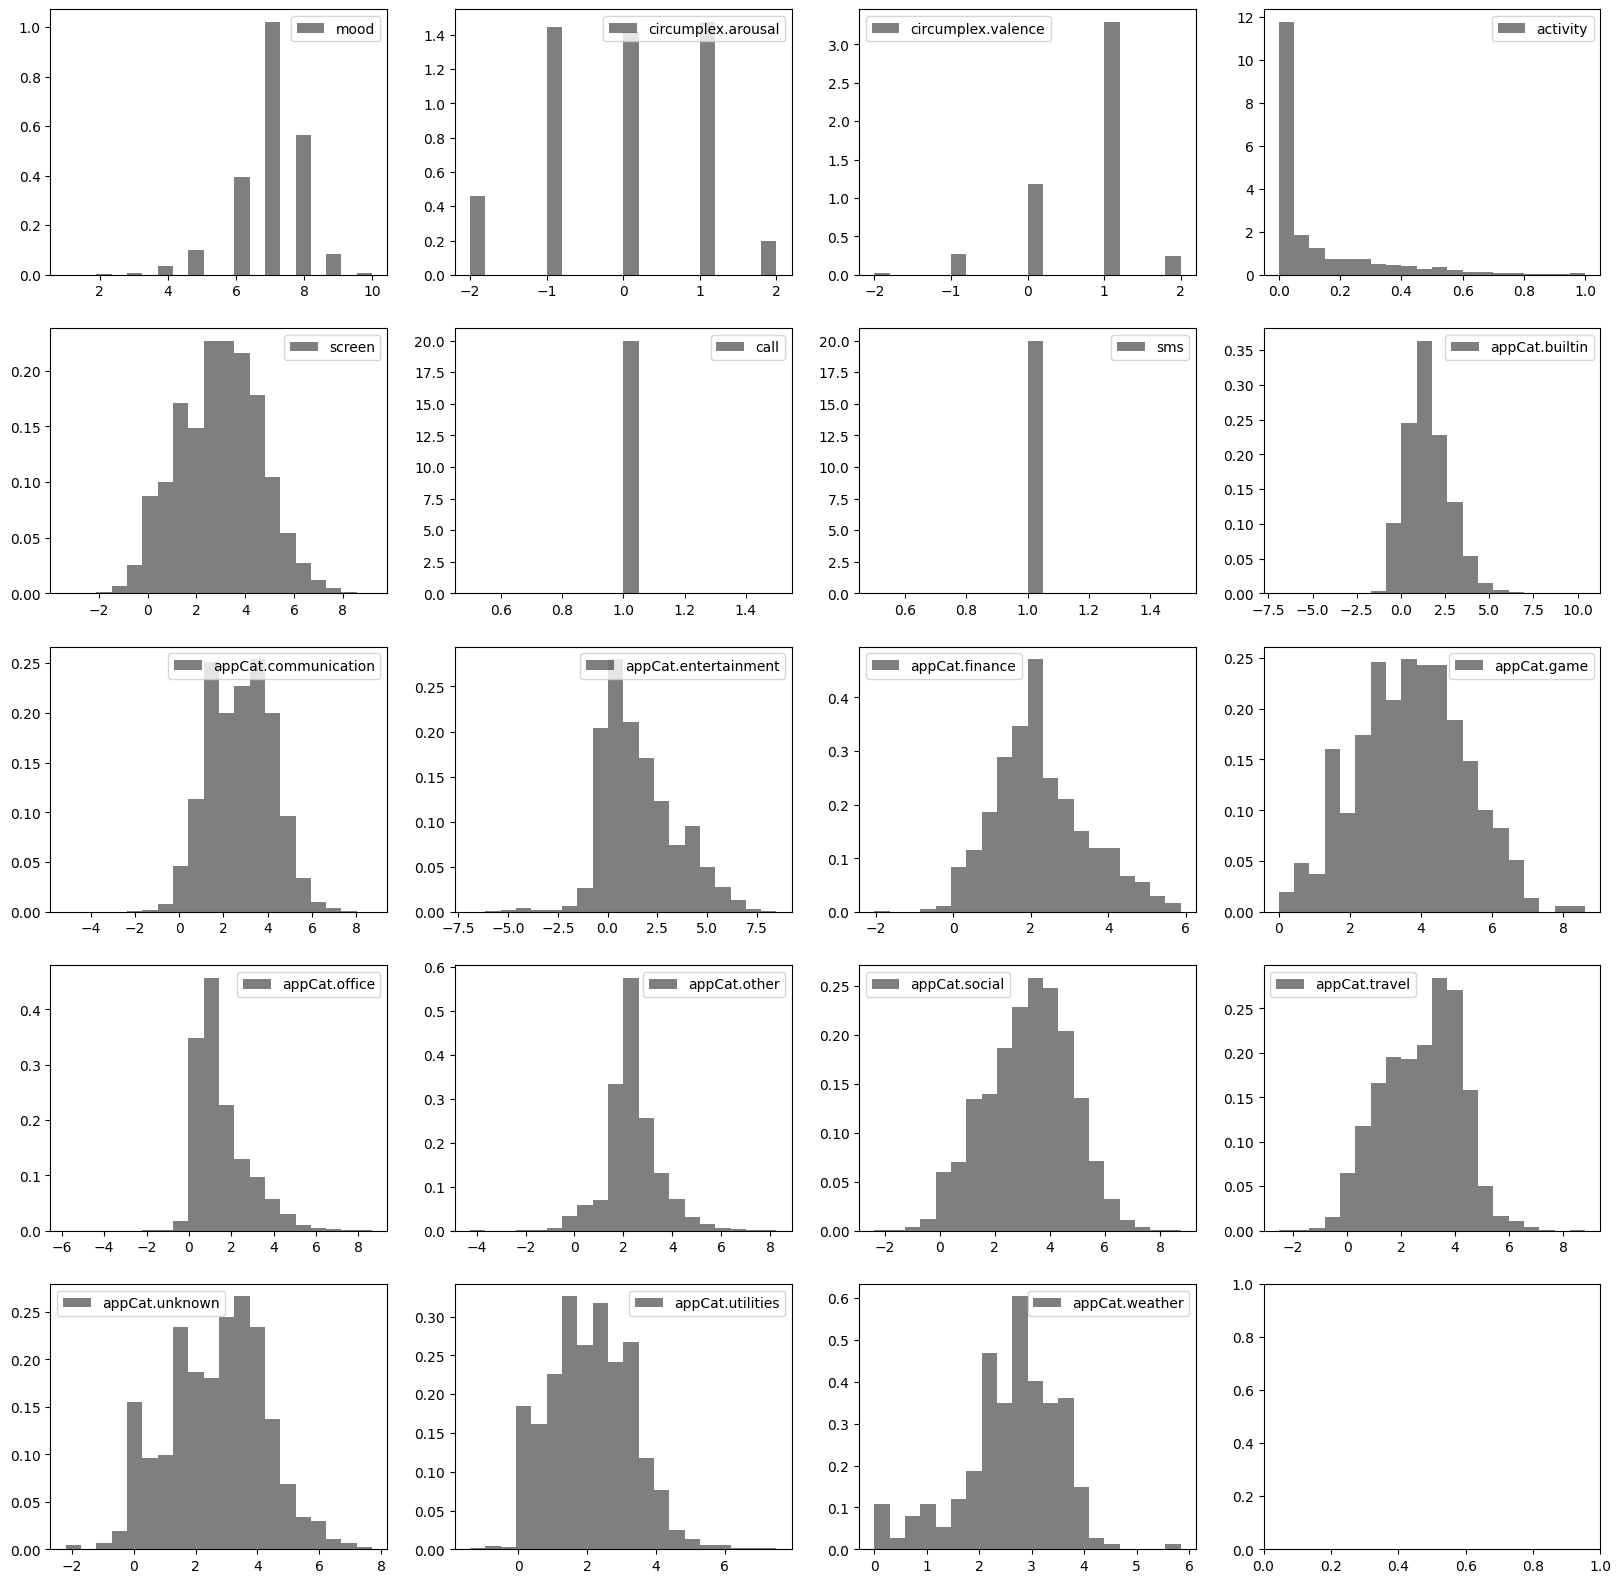

In [53]:
nrows, ncols = 5, 4
fig, axes = plt.subplots(nrows, ncols, sharex=False, figsize=(20, 20))

for idx, v in enumerate(Variable.variables()):
    values = get_values(transformed, v)

    ax = axes[idx // ncols, idx % ncols]
    ax.hist(
        values,
		bins=20,
		color="black",
		alpha=0.5,
		density=True,
        label=f"{v}"
    )

    ax.legend()

fig.savefig("output/imgs/hist_transformed.png")

#### Aggregating data

We aggregate the data from the cleaned data set with the transformed values with a frequency of 
one day. 

I'm unsure whether transforming the data and then aggregating is a correct approach. For the screen
time variables, you would be summing logarithmic values, wich is equivalent to multiplying the 
not transformed variables (?)

I therefore do this workaround where I first aggegate the clean data and then transform the 
variables


In [57]:
freq = "1D"
aggregated = agg_dates(cleaned, freq=freq)
aggregated.to_csv(f"output/data/aggregated{freq}.csv")

In [55]:
from transform import transformation_funs

# Replace the zeros in the columns where we're going to apply the log for nan
# values. They should actually be nan values.
replace_map = {
    "screen": 0.0,
    "appCat.builtin": 0.0,
    "appCat.communication": 0.0,
    "appCat.entertainment": 0.0,
    "appCat.finance": 0.0,
    "appCat.game": 0.0,
    "appCat.office": 0.0,
    "appCat.other": 0.0,
    "appCat.social": 0.0,
    "appCat.travel": 0.0,
    "appCat.unknown": 0.0,
    "appCat.utilities": 0.0,
    "appCat.weather": 0.0,
}

agg_transformed = aggregated.replace(to_replace=replace_map, value=np.nan).apply(transformation_funs)
agg_transformed.to_csv(f"output/data/agg_transformed{freq}.csv")

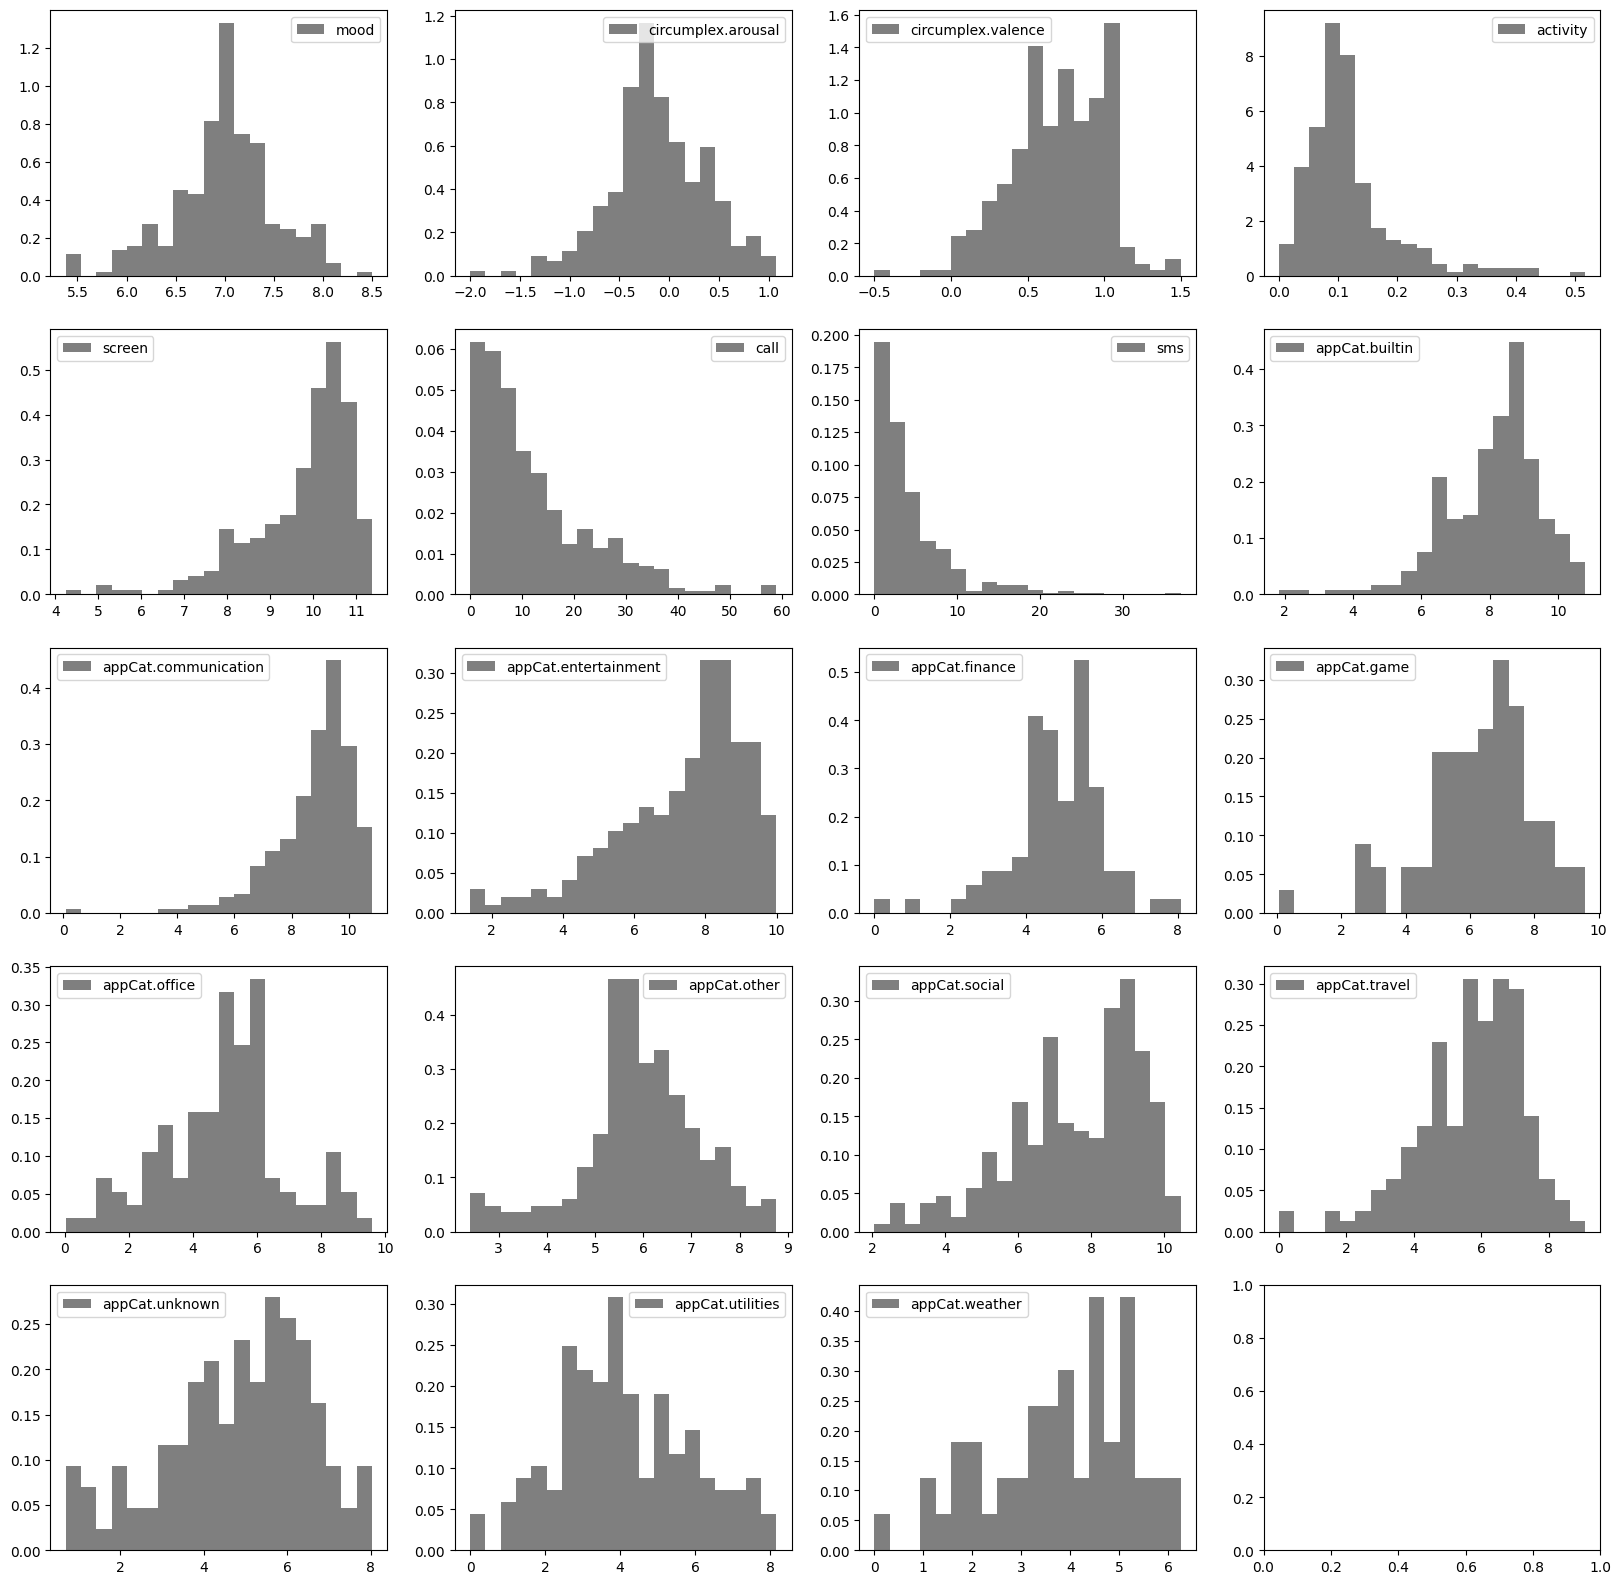

In [56]:
nrows, ncols = 5, 4
fig, axes = plt.subplots(nrows, ncols, sharex=False, figsize=(20, 20))

for idx, v in enumerate(Variable.variables()):
    values = agg_transformed[v]

    ax = axes[idx // ncols, idx % ncols]
    ax.hist(
        values,
		bins=20,
		color="black",
		alpha=0.5,
		density=True,
        label=f"{v}"
    )

    ax.legend()

plt.savefig("output/imgs/hist_agg_transformed.png")

# Classification

